In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
project_path = '/content/drive/MyDrive/anomaly-detection'

normal = pd.read_hdf(f'{project_path}/data/training_normal.h5')
faulty = pd.read_hdf(f'{project_path}/data/training_faulty.h5')
mean = pd.read_hdf(f'{project_path}/data/norm.h5', key='mean')
std = pd.read_hdf(f'{project_path}/data/norm.h5', key='std')

normal_data = normal.iloc[:, 3:]

normalized_data = (normal_data - mean) / std

normalized_data.head()

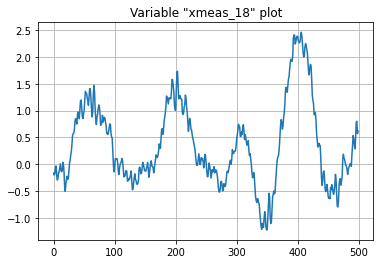

In [4]:
variable = 'xmeas_18'

plt.grid()
plt.plot(normalized_data.index[:500], normalized_data[variable][:500])
plt.title(f'Variable "{variable}" plot')
plt.show()

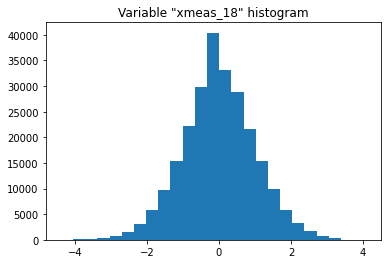

In [5]:
plt.hist(normalized_data[variable], bins=25)
plt.title(f'Variable "{variable}" histogram')
plt.show()

In [6]:
train_data, valid_data = train_test_split(normalized_data.values, test_size=0.2)
print(f'train data size: {train_data.shape}')
print(f'valid data size: {valid_data.shape}')

input_dim =  train_data.shape[1]

train_data = tf.cast(train_data, tf.float32)
valid_data = tf.cast(valid_data, tf.float32)

train data size: (200000, 52)
valid data size: (50000, 52)


In [7]:
class Autoencoder(Model):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(256, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(32, activation='relu')
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim)
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder(input_dim)

In [8]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.005), 
              loss=tf.losses.MeanSquaredError(), 
              metrics=[tf.metrics.MeanSquaredError()])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.5, 
                                                 patience=5, 
                                                 min_lr=0.0001,
                                                 verbose=1)

In [9]:
history = model.fit(train_data, train_data, 
                    epochs=100, 
                    batch_size=256, 
                    validation_data=(valid_data, valid_data), 
                    shuffle=True, 
                    callbacks=[reduce_lr])

Epoch 1/100
782/782 [==============================] - 6s 3ms/step - loss: 0.2259 - mean_squared_error: 0.2259 - val_loss: 0.1879 - val_mean_squared_error: 0.1879
Epoch 2/100
782/782 [==============================] - 2s 3ms/step - loss: 0.1745 - mean_squared_error: 0.1745 - val_loss: 0.1767 - val_mean_squared_error: 0.1767
Epoch 3/100
782/782 [==============================] - 2s 3ms/step - loss: 0.1739 - mean_squared_error: 0.1739 - val_loss: 0.1683 - val_mean_squared_error: 0.1683
Epoch 4/100
782/782 [==============================] - 2s 3ms/step - loss: 0.1713 - mean_squared_error: 0.1713 - val_loss: 0.1681 - val_mean_squared_error: 0.1681
Epoch 5/100
782/782 [==============================] - 2s 3ms/step - loss: 0.1683 - mean_squared_error: 0.1683 - val_loss: 0.1644 - val_mean_squared_error: 0.1644
Epoch 6/100
782/782 [==============================] - 2s 3ms/step - loss: 0.1688 - mean_squared_error: 0.1688 - val_loss: 0.1640 - val_mean_squared_error: 0.1640
Epoch 7/100
782/782 [=

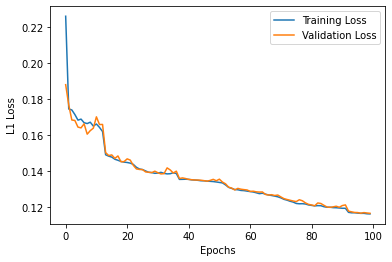

In [10]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('L2 Loss')
plt.legend()

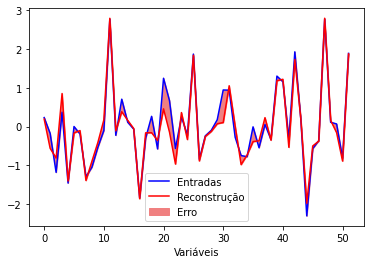

In [16]:
encoded_data = model.encoder(train_data).numpy()
decoded_data = model.decoder(encoded_data).numpy()

index = 203
plt.plot(train_data[index], 'b')
plt.plot(decoded_data[index], 'r')
plt.fill_between(np.arange(52), decoded_data[index], train_data[index], color='lightcoral')
plt.legend(labels=["Entradas", "Reconstrução", "Erro"])
plt.xlabel('Variáveis')
plt.show()

In [17]:
encoded_data[index]

array([0.66711915, 0.33686674, 0.        , 0.9547229 , 0.84064704,
       0.8818988 , 0.33507442, 0.48958233, 0.        , 0.7395634 ,
       0.14552324, 0.4656702 , 0.36410576, 0.        , 0.        ,
       0.56579334, 0.7666325 , 0.81670374, 0.6997379 , 0.7398561 ,
       0.66150165, 0.67270464, 0.5740293 , 0.582566  , 0.5278073 ,
       0.7144195 , 0.        , 1.0472083 , 1.0192884 , 0.4571349 ,
       0.40750283, 0.6271712 ], dtype=float32)

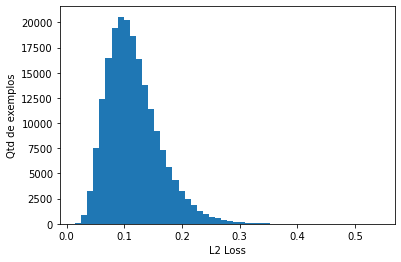

In [19]:
reconstructions = model.predict(train_data)
train_loss = tf.keras.losses.mse(reconstructions, train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("L2 Loss")
plt.ylabel("Qtd de exemplos")
plt.show()